In [1]:
import os
import sys
import requests
import datetime
import pandas as pd
import numpy as np
import torch, torchvision, torchaudio
import pytorch_lightning as pl
import wandb
import json
import copy
import shutil

import matplotlib.pyplot as plt
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import WandbLogger
from transformers import AutoImageProcessor, DetaForObjectDetection, AutoModelForObjectDetection
from pytorch_lightning import Trainer
from PIL import Image, ImageDraw

In [2]:


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, image_name):
        ann_file = os.path.join(img_folder, image_name)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

image_processor = AutoImageProcessor.from_pretrained("microsoft/conditional-detr-resnet-50")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Train and Validation Dataset
  #Minimal Dataset
# train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train', processor=processor, image_name="coco_train.json")
# val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val', processor=processor, image_name="coco_val.json")

  #Maximal Dataset
train_dataset = CocoDetection(img_folder='../../../old/BAA/Data/train_max', image_processor=image_processor, image_name="coco_train_max.json")
val_dataset = CocoDetection(img_folder='../../../old/BAA/Data/val_max', image_processor=image_processor, image_name="coco_val_max.json")

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
label2id = {v['name']: k  for k,v in cats.items()}

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = image_processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))



The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 859
Number of validation examples: 215


In [3]:
class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("microsoft/conditional-detr-resnet-50",
                                                             id2label=id2label,
                                                             label2id=label2id,
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.save_hyperparameters()
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [4]:
# Training




# login to weights and biases, to relogin: wandb.login(key="YOUR KEY", relogin=True)
wandb.login()

date = datetime.datetime.now()
run_name = "Run at the {}".format(date)

lr = 1e-4
lr_backbone=1e-5
weight_decay=1e-4

project = "BAA_Book_Damage_Detection"

wandb.init(
    project=project,
    name=run_name,
    config={"learning_rate_transformer": lr,
            "learning_rate_backbone": lr_backbone,
            "weight_decay": weight_decay,
            "architecture": "CondistionalDETR",
            "dataset": "All_Data",
            "train_set_size": len(train_dataset)}
    )

model = Detr(lr=lr, lr_backbone=lr_backbone, weight_decay=weight_decay)

model.to(device)

# outputs = model(pixel_values=batch['pixel_values'].to(device), pixel_mask=batch['pixel_mask'].to(device))
# print(outputs.logits.shape)

max_steps_var = 5000

wandb_logger = WandbLogger("CondistionalDETR", "../models/", project=project, log_model=True, checkpoint_name=f"CondistionalDETR_{max_steps_var}_Steps")
trainer = Trainer(max_steps=max_steps_var, gradient_clip_val=0.1, logger=wandb_logger)
trainer.fit(model)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michael-infanger (damaged-books-detection-ml). Use `wandb login --relogin` to force relogin


Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.


In [9]:
# load the checkpoint

run = wandb.init()
artifact = run.use_artifact('damaged-books-detection-ml/BAA_Book_Damage_Detection/CondistionalDETR_5000_Steps:v0', type='model')
artifact_dir = artifact.download()

model = Detr.load_from_checkpoint(artifact_dir + "/model.ckpt")



wandb: Downloading large artifact CondistionalDETR_5000_Steps:v0, 495.87MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5
Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([10]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Detr(
  (model): ConditionalDetrForObjectDetection(
    (model): ConditionalDetrModel(
      (backbone): ConditionalDetrConvModel(
        (conv_encoder): ConditionalDetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): ConditionalDetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): ConditionalDetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): ConditionalDetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=T

In [11]:
# Evaluation

def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results




# initialize evaluator with ground truth (gt)
evaluator = CocoEvaluator(coco_gt=val_dataset.coco, iou_types=["bbox"])

print("Running evaluation...")
for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

    # provide to metric
    # metric expects a list of dictionaries, each item
    # containing image_id, category_id, bbox and score keys
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()
print(evaluator)

Running evaluation...


  0%|          | 0/108 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

{'scores': tensor([0.4260, 0.3078, 0.2966, 0.2723, 0.2645, 0.2632, 0.2584, 0.2539, 0.2530,
        0.2521, 0.2472, 0.2465, 0.2457, 0.2436, 0.2325, 0.2316, 0.2307, 0.2289,
        0.2258, 0.2173, 0.2164, 0.2161, 0.2160, 0.2154, 0.2150, 0.2146, 0.2141,
        0.2140, 0.2132, 0.2121, 0.2119, 0.2103, 0.2095, 0.2074, 0.2061, 0.2026,
        0.2019], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 454.5139,  551.3976,  480.5101,  583.0515],
        [1235.0448,  430.7664, 1278.2203,  595.0568],
        [ 529.1653,  313.5570,  596.9754,  589.3624],
        [1226.4564,  407.8870, 1265.7410,  576.5213],
        [ 529.3842,  308.2180,  598.7943,  586.2881],
        [1241.9346,  412.0818, 1277.8306,  574.4666],
        [ 461.9917,  559.0927,  489.0187,  587.0517],
        [ 451.4055,  546.5070,  476.7265,  576.3565],
        [1233.7238,  653.5107, 1274.8

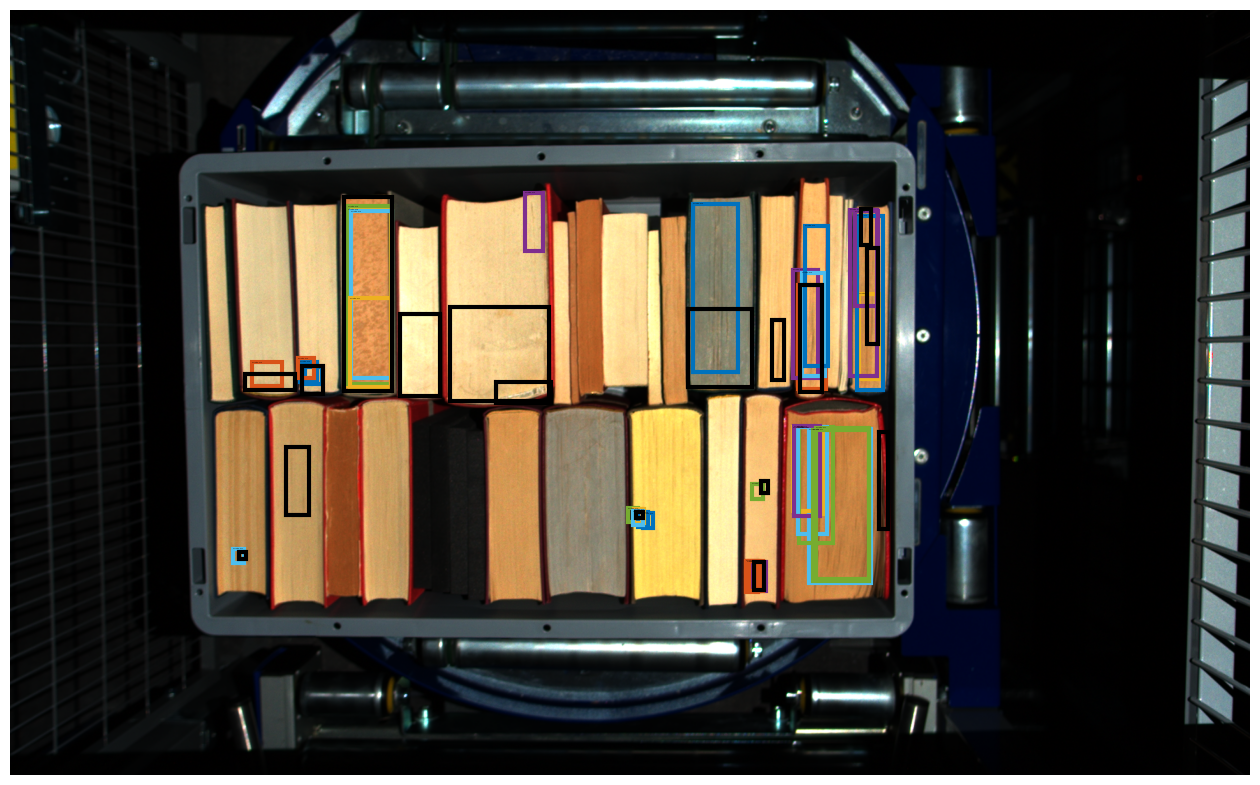

{'scores': tensor([0.4531, 0.3613, 0.3332, 0.3162, 0.2939, 0.2934, 0.2931, 0.2867, 0.2819,
        0.2800, 0.2753, 0.2746, 0.2695, 0.2657, 0.2393, 0.2391, 0.2390, 0.2356,
        0.2336, 0.2331, 0.2312, 0.2310, 0.2287, 0.2254, 0.2193, 0.2192, 0.2170,
        0.2154, 0.2114, 0.2111, 0.2086, 0.2073, 0.2069, 0.2066, 0.2061, 0.2056,
        0.2046, 0.2029, 0.2019, 0.2018, 0.2015], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 342.2627,  670.3777,  358.4330,  689.4407],
        [ 353.0626,  676.7591,  370.7985,  696.2764],
        [1201.8907,  357.2921, 1227.0432,  420.6310],
        [1274.1487,  320.6475, 1330.7662,  554.6211],
        [ 328.7644,  666.7127,  347.3685,  688.0895],
        [1276.0658,  360.0020, 1335.0962,  558.3967],
        [1281.1953,  653.6100, 1315.4415,  722.5480],
        [1040.3721,  335.4481, 1096.1637,  541.

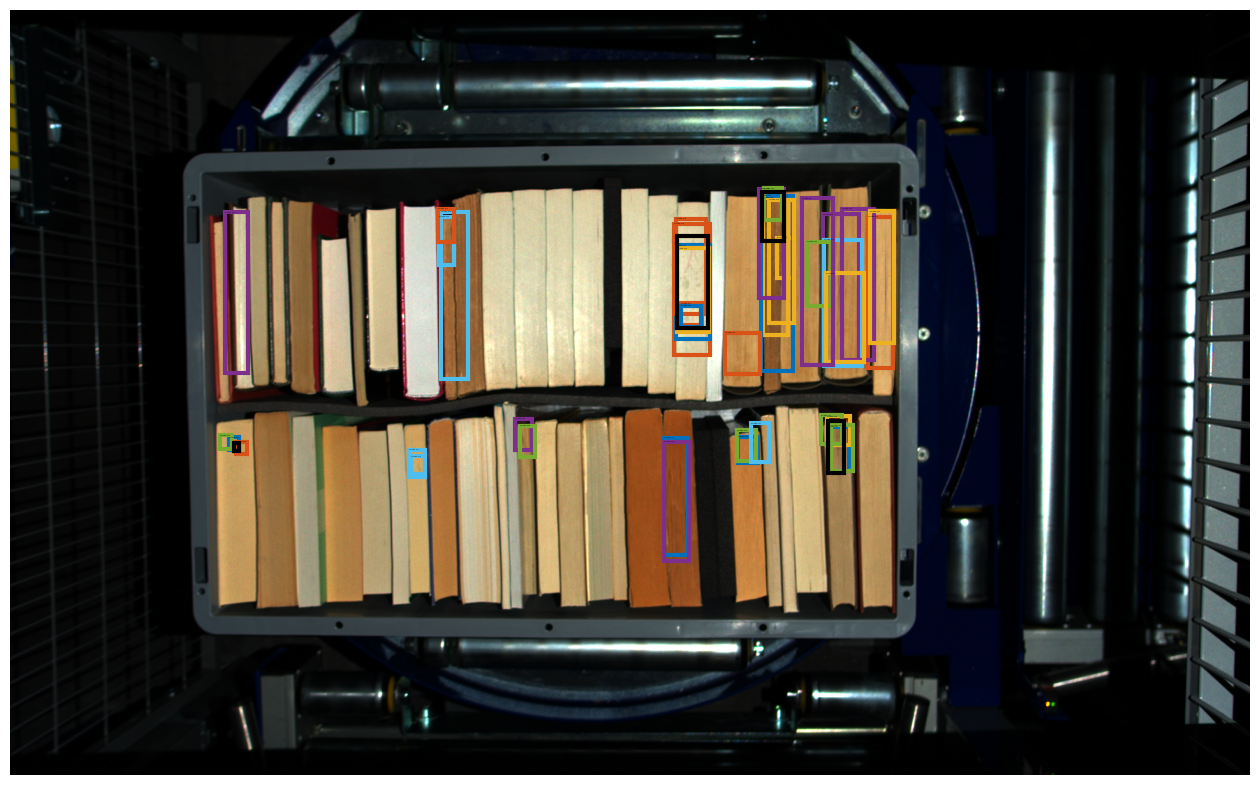

{'scores': tensor([0.3560, 0.3350, 0.3345, 0.3268, 0.3239, 0.3237, 0.3097, 0.3036, 0.2967,
        0.2769, 0.2748, 0.2710, 0.2676, 0.2659, 0.2638, 0.2607, 0.2590, 0.2587,
        0.2570, 0.2541, 0.2506, 0.2493, 0.2469, 0.2442, 0.2429, 0.2419, 0.2403,
        0.2401, 0.2343, 0.2323, 0.2305, 0.2296, 0.2170, 0.2111, 0.2107, 0.2071,
        0.2059, 0.2055, 0.2043, 0.2035, 0.2015, 0.2013], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 6, 3, 6, 6, 3, 3, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 6, 3, 3, 3,
        3, 6, 3, 6, 3, 6, 3, 3, 6, 4, 3, 3, 3, 3, 3, 6, 3, 3], device='cuda:0'), 'boxes': tensor([[ 680.5121,  780.4526,  707.6224,  807.0652],
        [ 886.1163,  606.6667,  917.6173,  639.4198],
        [1088.9923,  533.3915, 1124.7733,  583.7801],
        [ 882.6960,  613.1102,  909.4894,  645.2840],
        [1126.3051,  613.9819, 1152.3988,  657.9316],
        [1246.5148,  615.1004, 1274.4794,  712.1105],
        [ 928.4250,  614.2557,  962.3086,  653.4905],
        [ 886.1163,  606.6667,  917.

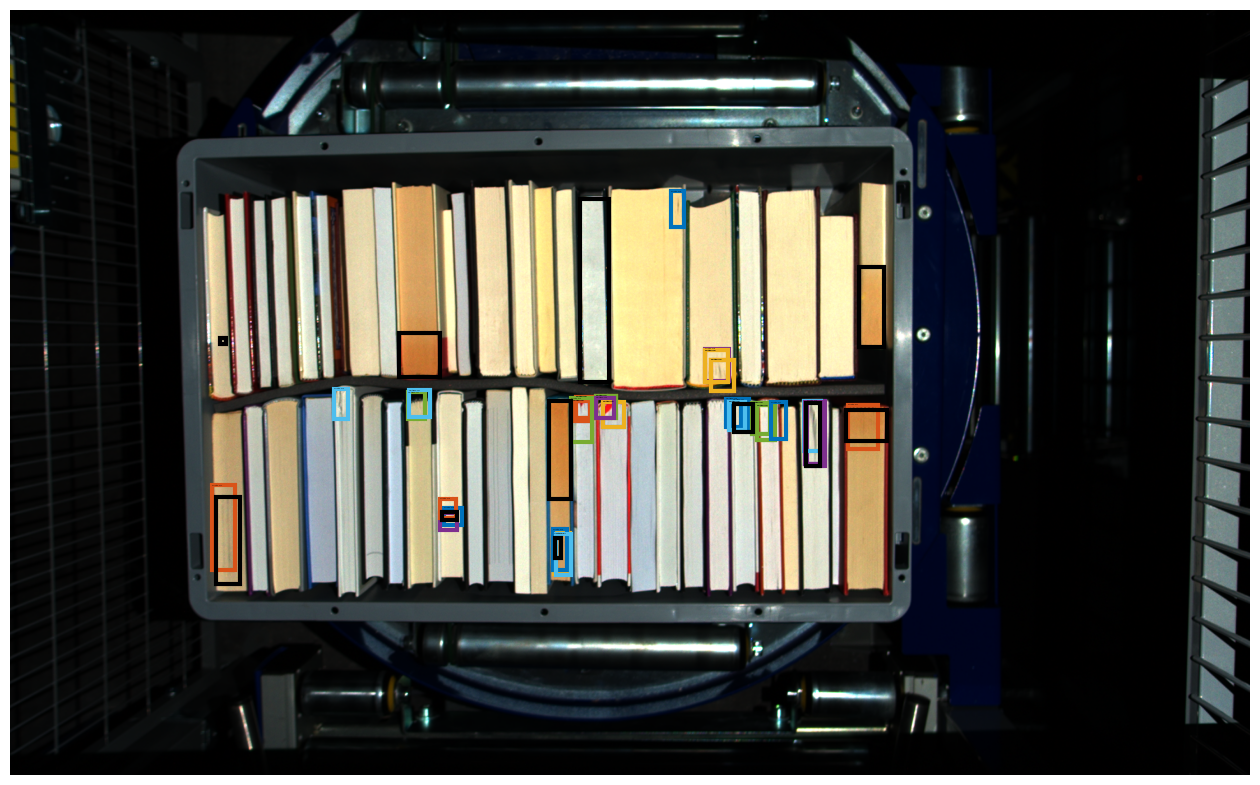

{'scores': tensor([0.3754, 0.3280, 0.3152, 0.2992, 0.2925, 0.2796, 0.2738, 0.2699, 0.2394,
        0.2340, 0.2197, 0.2133, 0.2111, 0.2108, 0.2065, 0.2063, 0.2053, 0.2046,
        0.2045, 0.2043, 0.2036, 0.2006], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0'), 'boxes': tensor([[ 395.5514,  471.3275,  430.5429,  508.6501],
        [ 398.4171,  371.6842,  434.0443,  402.1592],
        [ 399.8486,  371.6644,  433.5350,  410.0388],
        [ 324.2130,  356.0567,  351.5450,  384.2408],
        [ 447.6099,  275.3152,  500.7385,  467.6788],
        [1319.6548,  613.9243, 1352.0975,  677.6127],
        [ 440.0642,  284.3505,  499.7979,  512.1161],
        [ 385.3846,  444.9095,  420.8378,  480.6741],
        [1183.4469,  635.0389, 1219.2758,  678.2256],
        [1038.8318,  648.6683, 1080.2838,  719.8352],
        [1331.8665,  615.7960, 1356.3148,  670.0446],
        [1092.4222,  652.6423, 1128.5720,  750.8663],
   

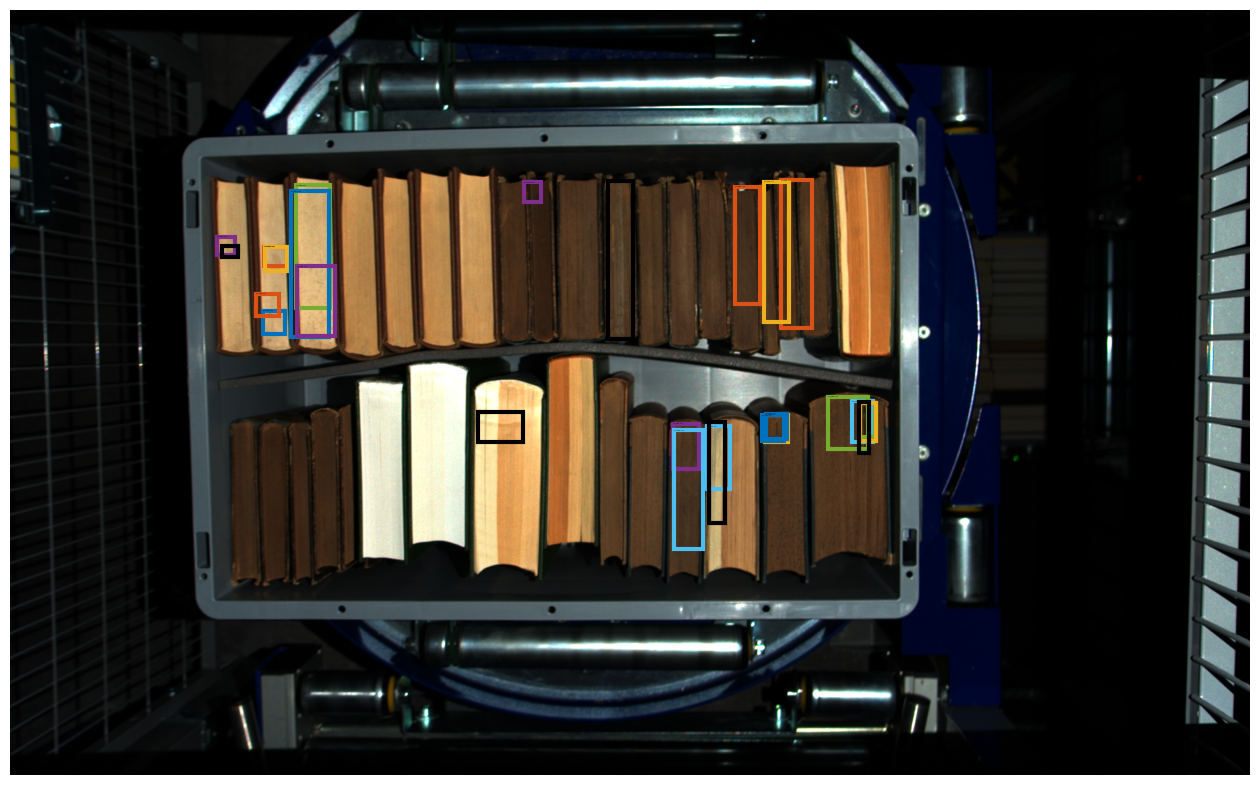

{'scores': tensor([0.3472, 0.2948, 0.2852, 0.2849, 0.2740, 0.2322, 0.2213, 0.2096, 0.2077,
        0.2076], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0'), 'boxes': tensor([[ 464.1784,  525.9419,  483.3893,  550.5539],
        [1285.3927,  586.0225, 1321.7289,  666.4283],
        [1031.0760,  595.5101, 1064.3223,  649.9469],
        [1037.6752,  597.7736, 1069.8456,  651.8808],
        [1289.4659,  594.7583, 1324.5865,  667.1834],
        [ 947.8670,  601.3962, 1005.5137,  683.2397],
        [1210.5536,  278.6820, 1280.1613,  542.6707],
        [1042.0469,  860.7759, 1063.1356,  901.5789],
        [ 884.8290,  599.0748,  931.7477,  661.7515],
        [1139.3215,  594.5018, 1168.4730,  635.3905]], device='cuda:0')}
{'Schmutz': 10}
{'Sonstiges': 2, 'Schmutz': 6}


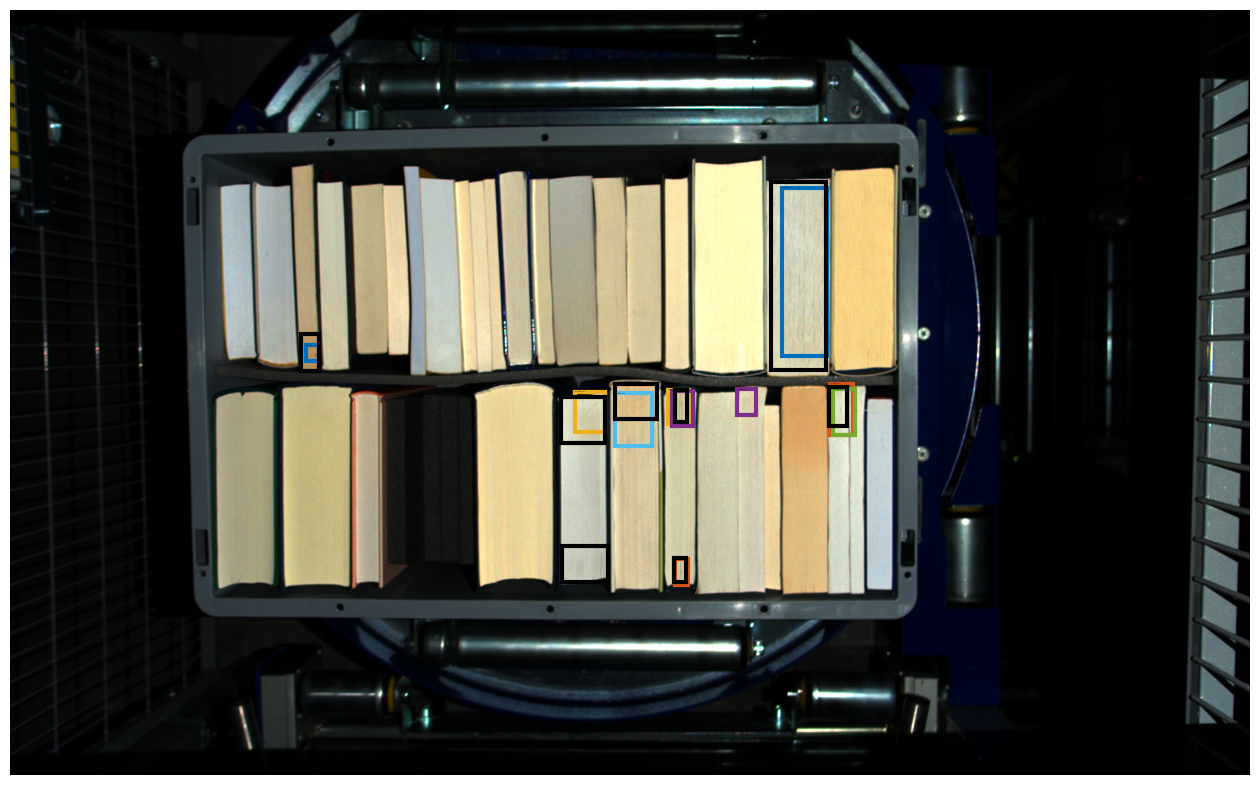

{'scores': tensor([0.3827, 0.3654, 0.3353, 0.3283, 0.3154, 0.3106, 0.3072, 0.2976, 0.2868,
        0.2858, 0.2797, 0.2784, 0.2777, 0.2766, 0.2746, 0.2718, 0.2692, 0.2597,
        0.2551, 0.2550, 0.2535, 0.2525, 0.2518, 0.2479, 0.2462, 0.2458, 0.2443,
        0.2407, 0.2378, 0.2361, 0.2348, 0.2336, 0.2322, 0.2295, 0.2282, 0.2255,
        0.2242, 0.2212, 0.2184, 0.2161, 0.2158, 0.2109, 0.2107, 0.2094, 0.2068,
        0.2067, 0.2053, 0.2048, 0.2027, 0.2009], device='cuda:0'), 'labels': tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6,
        3, 3], device='cuda:0'), 'boxes': tensor([[ 392.4483,  789.9637,  417.0213,  807.8392],
        [ 600.9864,  704.9148,  666.7775,  733.7960],
        [ 981.1280,  538.2689, 1012.6423,  555.1030],
        [1142.3979,  288.7220, 1197.8054,  310.4582],
        [ 617.8456,  323.2473,  666.9174,  346.2464],
        [ 532.1508,  475.3582,  570.9094

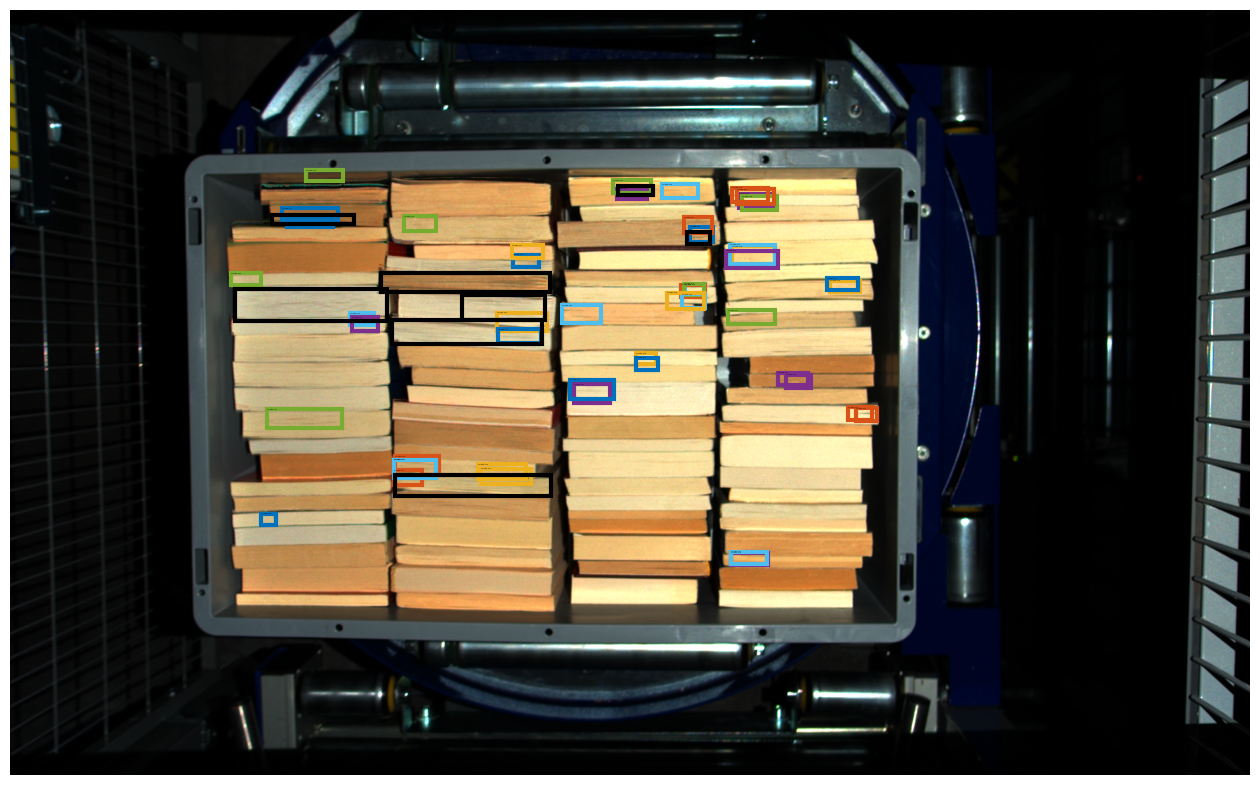

In [13]:
# Visualize
for z in range(6):
    pixel_values, target = val_dataset[z]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    

    annotations = val_dataset.coco.imgToAnns["image_id"]

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
            [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    def plot_results(pil_img, scores, labels, boxes, anno):
        plt.figure(figsize=(16,10))
        plt.imshow(pil_img)
        ax = plt.gca()
        colors = COLORS * 100
        types = {}
        for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            textx = text.split(": ")
            if textx[0] in types:
                types.update({textx[0]: types[textx[0]] + 1})
            else: 
                types.update({textx[0]:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='yellow', alpha=0.0))
        print(types)
        
        # draw annotatet boxes
        typesAnno = {}
        color = [0.000, 0.000, 0.000]
        # TODO Resize bbox
        for annot in anno:
            (x, y, w, h) = annot["bbox"]
            (xmin, ymin, xmax, ymax) = (x, y, x + w, y + h)
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color=color, linewidth=3))
            text = f'{id2label[annot["category_id"]]}'
            if text in typesAnno:
                typesAnno.update({text: typesAnno[text] + 1})
            else: 
                typesAnno.update({text:1})
            ax.text(xmin, ymin, text, fontsize=0,
                    bbox=dict(facecolor='yellow', alpha=0.0))
        print(typesAnno)
        plt.axis('off')
        plt.show()

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    anno = val_dataset.coco.imgToAnns[image_id]
    image = Image.open(os.path.join('../../../old/BAA/Data/val_max', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = image_processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.2)
    results = postprocessed_outputs[0]
    print(results)
    plot_results(image, results['scores'], results['labels'], results['boxes'], anno)

    def save_predicted():
        # TODO output der boxen im coco format um nach dem annotieren direkt das ganze im trainingsdatensatz abspeichern zu können
        pass 